In [51]:
import numpy as np
from tqdm import tqdm
import random
import gymnasium as gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque

In [52]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode='ansi')
state, _ = env.reset()

# The state of the environment
print(state)

print("decoded state")
print(list(env.decode(state)))


#The number of states in the environment
print(env.observation_space.n)

#The number of actions in the environment
print(env.action_space.n)

#Take a step in the environment
next_state, reward, done, _, _ = env.step(1)
print("decoded state")
print(list(env.decode(next_state)))

#Render the environment
env.render()

6
decoded state
[0, 0, 1, 2]
500
6
decoded state
[0, 0, 1, 2]


c:\Users\maste\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


'+---------+\n|\x1bR\x1b: | : :\x1bG\x1b|\n| : | : : |\n| : : : : |\n| | : | : |\n|\x1bY\x1b| : |B: |\n+---------+\n  (North)\n'

[![Options](https://www.researchgate.net/publication/292208109/figure/fig2/AS:960497125978114@1606011768506/Taxi-problem-and-an-action-hierarchy.gif)]

In [53]:
# actions:  ['down', 'up', 'right', 'left', 'pickup', 'dropoff']
actions = [0, 1, 2, 3, 4, 5]


goal_states = [[0, 0], [0, 4], [4, 0], [4, 3]]

level_1_options = [0, 1]
# highest level options: ['get', 'put']

get_put_options = [0, 1, 2, 3, 4]
# get options: ['pickup/dropff', 'getR', 'getG', 'getY', 'getB']


navigate_options = [0, 1, 2, 3]
# navigate options: ['down', 'up', 'right', 'left']
Q_level_one_options = np.zeros((500, 2)) # Q-values for level options -> get/put

Q_level_two_options = np.zeros((2, 500, len(get_put_options))) # Q-values for level options -> get/put, toR, toG, toY, toB

Q_level_three_options = np.zeros((4, 25, len(navigate_options))) # Q-values for level options -> down, up, right, left


# Softmax function
def softmax(Q, state, tau):
    q_values = Q[state]
    q_values = q_values / tau
    max_q = np.max(q_values)
    e = np.exp(q_values - max_q)
    dist = e / np.sum(e)
    action = np.random.choice(len(dist), p=dist)
    return action

def epsilon_greedy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, 4)
    else:
        action = np.argmax(Q[state])
    return action

In [54]:
def decode_state(env, state):
    return list(env.decode(state))

In [55]:
### HYPERPARAMETERS ###
ALPHA_Q = 0.2
ALPHA_OPTIONS = 0.3
ALPHA_OPTIONS_1 = 0.4
GAMMA = 0.99
TAU = 0.1
DECAY_CONSTANT = 0.995

In [56]:
def execute_level_1_selection(env, state, Q_level_one_options, Q_level_two_options, Q_level_three_options, option, policy, TAU):
    """
    Execute the level 1 selection

    Args:
    env: the environment
    state: the current state
    level_1_options: the level 1 options
    Q_level_two_options: Q-values for level 2 options
    Q_level_three_options: Q-values for level 3 options
    policy: the policy to use

    Returns:
    next_state: the next state
    reward: the reward
    done: is the episode done
    Q_level_two_options: updated Q-values for level 2 options
    Q_level_three_options: updated Q-values for level 3 options
    """
    
    if option < 2:
        """
        Get the Q-values for the level 2 options based on the option chosen
        Initialize the reward bar to 0
        Initialize the counter to 0
        Initialize the current state to the current state
        Get the Q-values for the chosen option
        Update the Q-values for the chosen option based on the reward and the Q-values for the next state
        """
        optdone = False
        optact = 0
        counter = 0
        reward_bar = 0
        chosen_q = Q_level_two_options[option]
        steps = 0
        while not optdone:
            optact = policy(chosen_q, state, TAU)
            next_state, reward, done, [Q_level_two_options, Q_level_three_options], pick_drop_flag, steps_level_2 = execute_level_2_options(env, Q_level_two_options, Q_level_three_options, state, option, optact, policy, TAU)
            reward_bar += reward * GAMMA**counter
            steps += steps_level_2
            chosen_q[state][optact] += ALPHA_OPTIONS * (reward + GAMMA * np.max(chosen_q[next_state]) - chosen_q[state][optact])
            if pick_drop_flag:
                # print("Enters here")
                optdone = True
                Q_level_one_options[state][option] += ALPHA_Q * (reward_bar - Q_level_one_options[state][option] + GAMMA ** counter * np.max(Q_level_one_options[next_state]))
            counter += 1
            state = next_state
        Q_level_two_options[option] = chosen_q
        return next_state, reward_bar, done, [Q_level_one_options, Q_level_two_options, Q_level_three_options], steps
    # else:
    #     next_state, reward, done, _, _ = env.step(option-2)
    #     Q_level_one_options[state][option] += ALPHA_Q * (reward - Q_level_one_options[state][option] + GAMMA * np.max(Q_level_one_options[next_state]))
    #     steps = 1
    #     return next_state, reward, done, [Q_level_one_options, Q_level_two_options, Q_level_three_options], steps


def execute_level_2_options(env, Q_level_two_options, Q_level_three_options, state, option_level_1, option_level_2, policy, TAU):
    """
    Execute the level 2 options

    Args:
    env: the environment
    Q_level_two_options: Q-values for level 2 options
    Q_level_three_options: Q-values for level 3 options 
    state: the current state
    option: the selected option
    level_1_option: the selected level 1 option
    policy: the policy to use

    Returns:
    next_state: the next state
    reward: the reward
    done: is the episode done
    Q_level_two_options: updated Q-values for level 2 options
    Q_level_three_options: updated Q-values for level 3 options
    """
    optdone = False
    optact = 0
    if option_level_2 == 0: # pickup/dropoff
        """
        Pickup or dropoff
        If level 1 option is get, and option is 0, then pickup(4)
        If level 1 option is put, and option is 0, then dropoff(5)    
        """
        if option_level_1 == 0:
            chosen_action = 4
        elif option_level_1 == 1:
            chosen_action = 5
        steps = 1

        """
        Execute the action if it is pickup or dropoff
        Update the Q-values for the level 2 options based on the reward (500, 5)
        """
        next_state, reward, done, _, _ = env.step(chosen_action)
        Q_level_two_options[option_level_1][state][option_level_2] +=  ALPHA_OPTIONS * (reward + GAMMA * np.max(Q_level_two_options[option_level_1][next_state]) - Q_level_two_options[option_level_1][state][option_level_2])
        """
        If the next state is the goal state, then the option is done
        Returns the next state, reward, done, Q-values for level 2 options, Q-values for level 3 options
        """
        # print("Pickup or dropoff")
        return next_state, reward, done, [Q_level_two_options, Q_level_three_options], True, steps
    
    else: # getR, getG, getY, getB
        """
        If the option is not pickup/dropoff, then it is getR, getG, getY, getB
        Get the index of the chosen action
        Initialize the reward bar to 0
        Initialize the counter to 0
        Initialize the current state to the current state
        Based on the chosen action, get the Q-values for the chosen action (25, 4)
        """
        reward_bar = 0
        chosen_action_index = get_put_options.index(option_level_2) - 1
        counter = 0
        current_state = state
        GOAL_REWARD = 0
        chosen_q = Q_level_three_options[chosen_action_index]
        while not optdone:
            """
            While the option is not done, do the following:
            Decode the state
            Get the state value
            Get the action based on the policy and chosen Q-values(25, 4), state value, and tau 
            Execute the action
            Get the next state value
            Update the reward bar
            Update the Q-values for the chosen action based on the reward and the Q-values for the next state
            """
            state_value = 5 * decode_state(env, state)[0] + decode_state(env, state)[1]
            optact = policy(chosen_q, state_value, TAU)
            next_state, reward, done, _, _ = env.step(optact)
            next_state_value = 5 * decode_state(env, next_state)[0] + decode_state(env, next_state)[1]
            reward_bar += reward*GAMMA**counter
            if decode_state(env, next_state)[:2] == goal_states[chosen_action_index]:
                """
                If the next state is the goal state, then the option is done
                Update the Q-values for the level 2 options based on the reward bar and the Q-values for the next state based on the option chosen by level 3 options
                """
                # print("Goal state reached")
                optdone = True
                GOAL_REWARD = 30
                Q_level_two_options[option_level_1][current_state][option_level_2] += ALPHA_OPTIONS * \
                    (reward_bar - Q_level_two_options[option_level_1][current_state][option_level_2] + \
                     GAMMA ** counter * np.max(Q_level_two_options[option_level_1][next_state]))
            chosen_q[state_value][optact] += ALPHA_OPTIONS_1 * (reward + GOAL_REWARD + GAMMA * np.max(chosen_q[next_state_value]) - chosen_q[state_value][optact])
            counter += 1
            state = next_state
        Q_level_three_options[chosen_action_index] = chosen_q
        steps = counter
        print(reward_bar)
        return next_state, reward_bar, done, [Q_level_two_options, Q_level_three_options], False, steps
                
            

In [57]:
#### SMDP Q-Learning
episodes = 2000


def SMDP_Q_Learning(env, Q_level_one_options, Q_level_two_options, Q_level_three_options, policy, TAU, DECAY_CONSTANT, episodes):
    # Iterate over 1000 episodes
    total_rewards = np.zeros((episodes))
    for i in tqdm(range(episodes)):
        state, _ = env.reset()    
        done = False
        # While episode is not over
        episode_steps = 0
        while not done:
            option = softmax(Q_level_one_options, state, TAU)
            # Choose and execute the level 1 option
            next_state, reward, done, value_array, steps = execute_level_1_selection(env, state, Q_level_one_options, Q_level_two_options, Q_level_three_options, option, policy, TAU)
            Q_values_level_1, Q_values_level_2, Q_values_level_3 = value_array
            state = next_state
            total_rewards[i] += reward
            TAU = max(0.01, TAU * DECAY_CONSTANT)
            episode_steps += steps
            # print(episode_steps)

    return Q_values_level_1, Q_values_level_2, Q_values_level_3, total_rewards


In [58]:
Q_level_one_options, Q_level_two_options, Q_level_three_options, total_rewards = SMDP_Q_Learning(env, Q_level_one_options, Q_level_two_options, Q_level_three_options, epsilon_greedy, TAU, DECAY_CONSTANT, episodes)

  0%|          | 0/2000 [00:00<?, ?it/s]

-59.11798255774501
-70.95115056900356
-61.895288189544964
-38.88827604671346
-1.0
-1.0
-2.9701
-3.940399
-1.0
-1.0
-5.8519850599
-1.0
-1.0
-71.52922267268039
-47.44035124744375
-40.70335535985002
-76.4783370759589
-68.83389185508568
-14.854222890512437
-68.83389185508568
-19.836941046095397
-28.94467727277075
-35.08973716315974
-90.66947834789299
-53.877803258190404
-13.994164535871148
-86.19191869125261
-28.226946740172476
-59.93153470484589
-14.854222890512437
-38.88827604671346
-1.0
-1.0
-1.99
-2.9701
-1.0
-1.0
-2.9701
-1.0
-1.0
-10.466174574128356
-52.94133584143496
-60.33221935779743
-51.01097269957946
-1.0
-4.90099501
-1.99
-9.561792499119552
-1.0
-1.0
-10.466174574128356
-46.90944570448864
-55.24767862361889
-61.121608192577256
-50.516134039979256
-1.99
-1.0
-1.0
-1.99
-1.0
-1.0
-16.548623854991238
-25.28279056684035
-1.0
-3.940399
-1.0
-1.0
-51.50086297258367
-9.561792499119552
-1.0
-1.0
-4.90099501
-1.0
-26.029962661171947
-1.0
-1.0
-5.8519850599
-39.499393286246324
-33.771795

  0%|          | 1/2000 [00:01<42:32,  1.28s/it]


-1.0
-5.8519850599
-1.0
-61.895288189544964
-51.985854342857834
-38.27098590577117
-19.02721317787414
-5.8519850599
-1.0
-1.0
-1.0
-73.7287412749771
-20.63857163563444
-1.0
-1.0
-15.705680661607312
-11.361512828387072
-1.0
-1.0
-1.99
-2.9701
-1.0
-1.0
-35.73883979152814
-1.99
-1.0
-1.0
-36.38145139361286
-38.88827604671346
-1.0
-1.0
-50.01629701008006
-50.01629701008006
-63.02703623502729
-47.44035124744375
-22.217864060085315
-62.65357195457302
-40.70335535985002
-1.0
-1.0
-1.99
-1.0
-13.12541872310217
-1.0
-1.99
-1.0
-1.0
-47.44035124744375
-12.247897700103202
-69.75955643309779
-62.65357195457302
-30.35867819504261
-31.744540498961264
-83.78301099889923
-1.0
-1.0
-1.99
-1.99
-1.0
-1.0
-10.466174574128356
-22.217864060085315
-1.0
-1.0
-65.53878166524818
-16.548623854991238
-7.72553055720799
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.99
-1.0
-7.72553055720799
-2.9701
-1.0
-5.8519850599
-1.0
-1.0
-19.02721317787414
-5.8519850599
-1.0
-1.0
-15.705680661607312
-32.42709509397165
-1.0
-1.0
-50.51613

  0%|          | 2/2000 [00:02<32:42,  1.02it/s]

-49.001425375043425
-1.0
-4.90099501
-1.0
-1.0
-22.217864060085315
-49.51141112129299
-1.0
-1.0
-1.0
-35.73883979152814
-52.46599579942926
-1.0
-79.35924628825853
-29.655230500043043
-67.22772425621957
-1.99
-1.0
-5.8519850599
-1.0
-6.793465209301
-1.0
-1.0
-2.9701
-1.0
-7.72553055720799
-38.88827604671346
-1.0
-65.8833938485957
-77.17695398646585
-1.99
-1.0
-7.72553055720799
-1.0
-32.42709509397165
-49.001425375043425
-76.24074452117061
-18.20930624027691
-1.0
-26.029962661171947
-1.0
-3.940399
-29.655230500043043
-77.85482127611381
-1.0
-2.9701
-1.0
-6.793465209301
-1.0
-1.0
-38.27098590577117
-2.9701
-1.0
-1.0
-65.19068855075574
-1.99
-1.0
-7.72553055720799
-1.0
-64.83907934419771
-1.0
-31.744540498961264
-1.0
-6.793465209301
-1.0
-1.0
-63.02703623502729
-4.90099501
-1.0
-1.0
-75.51347009650698
-32.42709509397165
-70.65772784747834
-5.8519850599
-1.0
-1.0
-45.8314924033146
-6.793465209301
-1.0
-1.0
-5.8519850599
-44.731652283761456
-1.0
-1.0
-2.9701
-1.99
-48.48628825761962
-1.0
-8.

  0%|          | 3/2000 [00:03<42:49,  1.29s/it]

-51.50086297258367
-20.63857163563444
-74.76393369106532
-1.0
-1.0
-1.99
-3.940399
-1.0
-1.0
-14.854222890512437
-1.99
-1.0
-1.0
-16.548623854991238
-1.0
-1.0
-55.24767862361889
-17.383137616441324
-1.0
-1.0
-61.895288189544964
-6.793465209301
-1.0
-6.793465209301
-1.0
-80.17257434110844
-82.24774732412354
-31.744540498961264
-78.72742967709803
-61.51039211065148
-1.0
-77.17695398646585
-47.44035124744375
-17.383137616441324
-75.01629435415467
-1.0
-1.0
-1.0
-1.0
-1.99
-1.0
-1.0
-1.0
-3.940399
-1.0
-1.0
-1.0
-1.0
-5.8519850599
-1.0
-1.0
-55.24767862361889
-1.0
-1.0
-1.0
-6.793465209301
-1.0
-1.0
-1.0
-51.50086297258367
-1.0
-1.0
-1.0
-76.00075204158648
-1.0
-1.0
-1.0
-51.50086297258367
-1.0
-1.0
-1.0
-62.65357195457302
-1.0
-1.0
-1.0
-62.27633530764951
-1.0
-1.0
-1.0
-84.10572908002112
-37.64746051087997
-72.3748332300791
-33.771795901601614
-49.51141112129299
-1.0
-9.561792499119552
-1.0
-1.0
-1.99
-1.0
-1.0
-4.90099501
-2.9701
-1.0
-1.0
-7.72553055720799
-4.90099501
-1.0
-38.27098590

  0%|          | 4/2000 [00:04<37:17,  1.12s/it]

-73.7287412749771
-18.20930624027691
-24.52807127963672
-82.06843164052883
-9.561792499119552
-7.72553055720799
-69.14555293653483
-31.055091413092185
-1.0
-3.940399
-56.13824981900887
-63.02703623502729
-1.0
-1.0
-3.940399
-1.0
-9.561792499119552
-1.0
-1.0
-1.99
-3.940399
-1.0
-1.0
-5.8519850599
-50.01629701008006
-1.0
-1.0
-6.793465209301
-4.90099501
-16.548623854991238
-1.0
-2.9701
-2.9701
-1.0
-1.0
-1.0
-1.99
-1.0
-47.44035124744375
-1.0
-1.0
-9.561792499119552
-7.72553055720799
-1.0
-8.64827525163591
-1.0
-53.877803258190404
-22.217864060085315
-1.0
-1.0
-59.52680273216756
-6.793465209301
-1.0
-1.0
-22.217864060085315
-35.08973716315974
-1.0
-75.51347009650698
-1.0
-76.24074452117061
-1.0
-13.12541872310217
-28.226946740172476
-1.0
-73.7287412749771
-81.14431548326218
-12.247897700103202
-1.0
-1.99
-52.94133584143496
-1.0
-1.0
-11.361512828387072
-1.99
-1.0
-1.0
-1.0
-10.466174574128356
-70.0619608687668
-1.0
-15.705680661607312
-1.0
-3.940399
-1.0
-79.15075382652377
-1.0
-29.6552

  0%|          | 5/2000 [00:04<27:46,  1.20it/s]

-63.76279821395025
-1.0
-1.0
-1.0
-84.10572908002112
-1.0
-1.0
-1.0
-1.0
-1.0
-3.940399
-1.0
-50.01629701008006
-1.0
-1.0
-79.35924628825853
-1.0
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-59.52680273216756
-1.0
-1.0
-1.0
-79.76999728712218
-1.0
-1.0
-1.0
-62.27633530764951
-54.3390252256085
-1.0
-1.0
-3.940399
-6.793465209301
-1.0
-32.42709509397165
-1.0
-6.793465209301
-79.56565382537595
-65.8833938485957
-1.0
-1.0
-8.64827525163591
-5.8519850599
-1.0
-1.0
-15.705680661607312
-68.2010936180856
-65.53878166524818
-49.001425375043425
-1.0
-3.940399
-1.0
-1.0
-5.8519850599
-1.0
-1.0
-1.0
-1.99
-56.57686732081878
-2.9701
-1.0
-58.2879120066779
-2.9701
-1.0
-1.0
-6.793465209301
-1.0
-62.27633530764951
-1.0
-20.63857163563444
-1.0
-56.13824981900887
-1.0
-26.769663034560228
-1.0
-34.434077942585596
-31.055091413092185
-1.0
-1.0
-48.48628825761962
-77.63113260213517
-55.24767862361889
-1.0
-2.9701
-1.0
-1.0
-2.9701
-1.0
-1.99
-6.793465209301
-1.0
-1.0
-1.0
-1.99
-10.466174574128356
-1.0
-1.0
-1.0
-3

  0%|          | 6/2000 [00:05<19:40,  1.69it/s]

-90.94660417148224
-1.0
-3.940399
-1.0
-13.12541872310217
-1.0
-5.8519850599
-1.0
-62.27633530764951
-1.0
-60.33221935779743
-36.38145139361286
-27.501966404214624
-76.00075204158648
-67.22772425621957
-16.548623854991238
-79.56565382537595
-1.0
-5.8519850599
-1.0
-6.793465209301
-1.0
-1.99
-1.0
-28.226946740172476
-1.0
-1.0
-1.99
-7.72553055720799
-1.0
-1.0
-32.42709509397165
-59.93153470484589
-1.0
-4.90099501
-1.0
-8.64827525163591
-1.0
-2.9701
-1.0
-8.64827525163591
-1.0
-42.46452500230711
-1.0
-86.46669950929667
-1.0
-14.854222890512437
-1.0
-3.940399
-1.0
-71.24163906331353
-38.88827604671346
-61.121608192577256
-40.70335535985002
-17.383137616441324
-46.90944570448864
-64.83907934419771
-1.0
-1.0
-1.99
-1.0
-1.99
-1.0
-4.90099501
-1.0
-1.0
-26.029962661171947
-12.247897700103202
-1.0
-1.0
-1.99
-1.99
-1.0
-1.0
-38.27098590577117
-26.029962661171947
-1.0
-47.96594773496931
-1.0
-1.0
-44.17338614521359
-4.90099501
-1.0
-1.0
-2.9701
-61.51039211065148
-1.0
-2.9701
-1.0
-65.53878166

  0%|          | 7/2000 [00:06<25:14,  1.32it/s]

-59.11798255774501
-6.793465209301
-1.0
-1.0
-75.01629435415467
-61.121608192577256
-15.705680661607312
-28.94467727277075
-1.0
-1.0
-33.10282414303193
-1.99
-74.50902393036901
-47.96594773496931
-1.0
-1.0
-1.0
-1.99
-1.0
-1.0
-1.0
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-3.940399
-1.0
-1.0
-1.0
-10.466174574128356
-1.0
-1.0
-47.96594773496931
-1.0
-1.0
-1.0
-40.10439935338386
-1.0
-1.0
-42.46452500230711
-1.0
-1.0
-1.0
-2.9701
-1.0
-22.217864060085315
-1.0
-81.7043481690938
-3.940399
-1.0
-1.0
-1.0
-1.0
-22.217864060085315
-1.0
-1.0
-1.0
-1.0
-50.516134039979256
-1.0
-1.0
-1.0
-68.2010936180856
-1.0
-63.02703623502729
-1.0
-1.0
-1.0
-63.396765872677015
-1.0
-1.0
-1.0
-45.8314924033146
-1.0
-1.0
-1.0
-61.51039211065148
-1.0
-1.0
-1.0
-58.2879120066779
-1.0
-1.0
-79.35924628825853
-22.217864060085315
-37.64746051087997
-25.28279056684035
-1.0
-4.90099501
-1.0
-1.0
-11.361512828387072
-6.793465209301
-1.0
-1.0
-46.90944570448864
-4.90099501
-1.0
-1.0
-67.22772425621957
-4.90099501
-1.0
-33.7717

  0%|          | 8/2000 [00:06<23:25,  1.42it/s]

-73.7287412749771
-75.7583353955419
-1.0
-1.0
-2.9701
-1.0
-1.0
-2.9701
-38.88827604671346
-1.0
-1.0
-1.99
-72.3748332300791
-1.0
-1.0
-15.705680661607312
-26.769663034560228
-1.0
-1.0
-15.705680661607312
-8.64827525163591
-1.0
-1.0
-4.90099501
-29.655230500043043
-1.0
-1.0
-49.51141112129299
-76.94641816814732
-1.0
-1.0
-7.72553055720799
-23.765728565289617
-1.0
-1.0
-44.731652283761456
-22.995685419484463
-1.0
-1.0
-72.09579114149405
-52.94133584143496
-75.26613141061311
-28.94467727277075
-8.64827525163591
-1.0
-1.0
-1.0
-80.76146871060318
-1.0
-1.0
-1.0
-66.89669116789857
-74.50902393036901
-44.731652283761456
-1.0
-1.0
-5.8519850599
-8.64827525163591
-1.0
-1.0
-2.9701
-4.90099501
-1.0
-1.0
-16.548623854991238
-51.01097269957946
-1.0
-1.0
-13.994164535871148
-50.01629701008006
-1.0
-1.0
-11.361512828387072
-58.2879120066779
-1.0
-1.0
-15.705680661607312
-6.793465209301
-1.0
-81.33287232842956
-1.0
-2.9701
-1.0
-55.6952018373827
-1.0
-2.9701
-72.3748332300791
-83.61920302919114
-1.0

  0%|          | 9/2000 [00:07<29:17,  1.13it/s]

-6.793465209301
-81.33287232842956
-68.2010936180856
-1.0
-1.0
-1.0
-19.836941046095397
-1.0
-1.0
-1.0
-1.0
-62.27633530764951
-1.0
-1.0
-59.11798255774501
-1.0
-1.0
-1.0
-4.90099501
-1.0
-1.0
-1.0
-71.24163906331353
-1.0
-1.0
-1.0
-41.29632180625152
-1.0
-1.0
-68.2010936180856
-1.0
-1.0
-1.0
-57.86657778452313
-1.0
-1.0
-78.07627306335267
-76.71355370519932
-1.0
-3.940399
-1.0
-2.9701
-1.0
-1.0
-15.705680661607312
-1.99
-1.0
-1.0
-2.9701
-1.0
-14.854222890512437
-1.0
-2.9701
-1.0
-28.94467727277075
-1.0
-2.9701
-57.44098766113448
-1.0
-1.0
-2.9701
-62.65357195457302
-1.0
-1.0
-5.8519850599
-67.22772425621957
-1.0
-1.0
-5.8519850599
-64.48391852949264
-1.0
-5.8519850599
-1.0
-54.3390252256085
-1.0
-30.35867819504261
-1.0
-41.29632180625152
-1.0
-2.9701
-1.0
-46.90944570448864
-3.940399
-1.0
-1.0
-67.8798925435208
-3.940399
-1.0
-71.81393044595359
-10.466174574128356
-1.0
-23.765728565289617
-1.0
-3.940399
-1.0
-2.9701
-1.0
-1.0
-29.655230500043043
-1.0
-51.01097269957946
-1.0
-51.98585

  0%|          | 10/2000 [00:08<22:49,  1.45it/s]

-71.24163906331353
-40.10439935338386
-1.0
-15.705680661607312
-74.25153932360506
-71.52922267268039
-43.039879752284044
-74.25153932360506
-61.121608192577256
-28.94467727277075
-1.0
-5.8519850599
-1.0
-1.0
-1.99
-1.0
-1.99
-1.0
-8.64827525163591
-1.0
-23.765728565289617
-1.0
-11.361512828387072
-1.0
-9.561792499119552
-1.0
-57.44098766113448
-1.0
-1.0
-47.44035124744375
-1.0
-45.8314924033146
-1.99
-70.0619608687668
-22.217864060085315
-40.10439935338386
-42.46452500230711
-6.793465209301
-1.0
-1.0
-64.83907934419771
-7.72553055720799
-21.432185919278098
-13.994164535871148
-17.383137616441324
-1.0
-1.0
-1.0
-3.940399
-1.0
-61.121608192577256
-16.548623854991238
-2.9701
-1.0
-1.99
-1.0
-1.0
-2.9701
-1.0
-45.8314924033146
-4.90099501
-1.0
-1.0
-4.90099501
-5.8519850599
-1.0
-1.0
-7.72553055720799
-34.434077942585596
-1.0
-8.64827525163591
-1.0
-23.765728565289617
-1.0
-6.793465209301
-1.0
-70.36134126007913
-1.0
-29.655230500043043
-50.516134039979256
-1.0
-1.0
-7.72553055720799
-64.8

  1%|          | 11/2000 [00:08<18:30,  1.79it/s]

-66.22455991010975
-1.0
-1.0
-1.0
-65.8833938485957
-1.0
-1.0
-1.0
-80.95385402349714
-59.52680273216756
-1.0
-2.9701
-1.0
-59.93153470484589
-62.65357195457302
-58.70503288661112
-30.35867819504261
-83.61920302919114
-72.65108489777832
-54.3390252256085
-51.50086297258367
-1.0
-3.940399
-1.0
-1.99
-1.0
-4.90099501
-1.0
-1.0
-52.46599579942926
-4.90099501
-1.0
-1.0
-9.561792499119552
-3.940399
-1.0
-1.0
-30.35867819504261
-3.940399
-1.0
-1.0
-5.8519850599
-40.70335535985002
-1.0
-1.0
-5.8519850599
-65.8833938485957
-1.0
-58.2879120066779
-1.0
-2.9701
-1.0
-52.94133584143496
-1.0
-3.940399
-1.0
-70.65772784747834
-49.001425375043425
-48.48628825761962
-13.12541872310217
-23.765728565289617
-1.0
-1.0
-1.99
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-5.8519850599
-1.0
-1.0
-1.0
-59.93153470484589
-1.0
-1.0
-69.14555293653483
-1.0
-1.0
-70.36134126007913
-1.0
-1.0
-1.0
-1.0
-22.995685419484463
-1.0
-1.0
-1.0
-71.52922267268039
-1.0
-1.0
-86.73601218906167
-1.0
-1.0
-1.0
-14.85422

  1%|          | 13/2000 [00:08<11:21,  2.92it/s]

-65.8833938485957
-1.0
-1.0
-61.51039211065148
-1.0
-1.0
-1.0
-58.2879120066779
-30.35867819504261
-81.33287232842956
-51.985854342857834
-1.0
-1.0
-2.9701
-13.994164535871148
-1.0
-1.0
-7.72553055720799
-49.51141112129299
-1.0
-1.0
-1.99
-11.361512828387072
-1.0
-1.0
-11.361512828387072
-16.548623854991238
-1.0
-1.0
-52.46599579942926
-58.2879120066779
-1.0
-1.0
-10.466174574128356
-55.6952018373827
-1.0
-1.0
-10.466174574128356
-80.95385402349714
-83.11778434193083
-32.42709509397165
-1.0
-1.0
-2.9701
-58.2879120066779
-1.0
-1.0
-2.9701
-1.0
-1.0
-4.90099501
-8.64827525163591
-56.57686732081878
-76.24074452117061
-1.0
-1.0
-74.25153932360506
-26.769663034560228
-63.76279821395025
-18.20930624027691
-1.0
-1.0
-1.0
-1.0
-1.0
-1.99
-48.48628825761962
-37.017636879676736
-49.001425375043425
-1.0
-1.0
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-21.432185919278098
-1.0
-1.0
-1.0
-31.744540498961264
-1.0
-1.0
-1.0
-61.51039211065148
-1.0
-1.0
-1.0
-61.121608192577256
-1.0
-1.0
-1.0
-65.8833938485957


  1%|          | 14/2000 [00:09<16:18,  2.03it/s]

-43.039879752284044
-1.0
-3.940399
-1.0
-1.99
-1.0
-10.466174574128356
-1.0
-1.0
-1.99
-1.0
-2.9701
-1.0
-57.86657778452313
-5.8519850599
-1.0
-63.396765872677015
-1.0
-3.940399
-1.0
-26.029962661171947
-1.0
-2.9701
-1.0
-82.60101715237347
-1.0
-2.9701
-1.0
-28.94467727277075
-1.0
-2.9701
-1.0
-67.8798925435208
-62.27633530764951
-63.396765872677015
-28.94467727277075
-59.93153470484589
-1.0
-6.793465209301
-1.0
-1.99
-1.0
-2.9701
-1.0
-1.0
-7.72553055720799
-1.0
-43.6094809547612
-29.655230500043043
-1.0
-37.64746051087997
-1.0
-31.744540498961264
-1.0
-57.86657778452313
-32.42709509397165
-78.72742967709803
-34.434077942585596
-57.44098766113448
-1.0
-1.0
-1.99
-1.99
-1.0
-1.0
-1.0
-1.0
-1.99
-31.744540498961264
-1.0
-1.0
-17.383137616441324
-5.8519850599
-1.0
-1.0
-1.99
-26.029962661171947
-1.0
-1.0
-34.434077942585596
-24.52807127963672
-31.744540498961264
-1.0
-1.0
-49.51141112129299
-11.361512828387072
-1.0
-1.0
-77.17695398646585
-6.793465209301
-1.0
-1.0
-9.561792499119552
-38.

  1%|          | 15/2000 [00:09<14:38,  2.26it/s]

-43.039879752284044
-60.33221935779743
-42.46452500230711
-1.0
-6.793465209301
-1.0
-2.9701
-1.0
-1.0
-2.9701
-32.42709509397165
-1.0
-1.0
-10.466174574128356
-13.994164535871148
-1.0
-1.0
-5.8519850599
-1.0
-7.72553055720799
-1.0
-10.466174574128356
-1.0
-1.99
-1.0
-86.05244312247738
-1.0
-63.02703623502729
-1.0
-4.90099501
-1.0
-36.38145139361286
-1.0
-5.8519850599
-1.0
-1.99
-1.0
-55.6952018373827
-1.0
-1.99
-55.6952018373827
-1.0
-1.0
-55.6952018373827
-87.88311836429506
-17.383137616441324
-47.96594773496931
-30.35867819504261
-35.73883979152814
-27.501966404214624
-48.48628825761962
-73.99145386222733
-1.0
-1.0
-3.940399
-21.432185919278098
-1.0
-2.9701
-1.0
-34.434077942585596
-1.0
-1.99
-1.0
-68.83389185508568
-1.0
-1.99
-1.0
-61.895288189544964
-50.516134039979256
-81.33287232842956
-1.0
-1.0
-2.9701
-46.37317747928145
-1.0
-1.0
-9.561792499119552
-2.9701
-1.0
-1.0
-16.548623854991238
-7.72553055720799
-1.0
-53.41192248302061
-1.0
-3.940399
-1.0
-80.76146871060318
-22.99568541

  1%|          | 17/2000 [00:10<11:51,  2.79it/s]

-80.95385402349714
-48.48628825761962
-61.895288189544964
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-1.0
-1.0
-8.64827525163591
-1.0
-1.0
-1.0
-54.79563497335241
-1.0
-1.0
-1.0
-1.0
-57.44098766113448
-1.0
-1.0
-59.11798255774501
-1.0
-1.0
-1.0
-61.51039211065148
-1.0
-1.0
-1.0
-67.22772425621957
-19.836941046095397
-1.0
-1.99
-1.0
-3.940399
-1.0
-1.0
-2.9701
-1.0
-1.99
-1.0
-1.0
-6.793465209301
-1.0
-4.90099501
-4.90099501
-1.0
-1.0
-9.561792499119552
-2.9701
-1.0
-1.0
-19.836941046095397
-4.90099501
-1.0
-1.0
-29.655230500043043
-1.99
-1.0
-53.877803258190404
-1.0
-1.99
-1.0
-56.57686732081878
-1.0
-2.9701
-1.0
-59.52680273216756
-1.0
-2.9701
-1.0
-52.94133584143496
-1.0
-2.9701
-1.0
-66.22455991010975
-1.0
-59.52680273216756
-72.92457404880054
-1.0
-1.0
-42.46452500230711
-1.0
-1.0
-1.0
-63.76279821395025
-1.0
-1.0
-1.0
-56.57686732081878
-1.0
-1.0
-76.24074452117061
-1.0
-1.0
-1.0
-61.895288189544964
-1.0
-1.0
-1.0
-59.93153470484589
-1.0
-1.0
-49.001425375043425
-1.0
-1.0
-1.0
-71.81393044

  1%|          | 18/2000 [00:10<13:27,  2.46it/s]

-7.72553055720799
-55.24767862361889
-1.0
-1.0
-44.731652283761456
-27.501966404214624
-1.0
-1.0
-45.28433576092384
-28.94467727277075
-1.0
-1.0
-68.2010936180856
-33.10282414303193
-71.52922267268039
-1.0
-1.0
-14.854222890512437
-5.8519850599
-1.0
-1.0
-3.940399
-9.561792499119552
-1.0
-1.0
-5.8519850599
-47.96594773496931
-1.0
-5.8519850599
-1.0
-58.70503288661112
-1.0
-4.90099501
-1.0
-52.46599579942926
-1.0
-5.8519850599
-1.0
-60.728897164219454
-1.0
-7.72553055720799
-57.86657778452313
-1.0
-53.877803258190404
-66.22455991010975
-8.64827525163591
-1.0
-1.0
-2.9701
-1.0
-1.0
-22.995685419484463
-5.8519850599
-1.0
-1.0
-54.3390252256085
-7.72553055720799
-1.0
-1.0
-54.3390252256085
-7.72553055720799
-72.3748332300791
-1.0
-1.0
-20.63857163563444
-9.561792499119552
-1.0
-1.0
-30.35867819504261
-57.86657778452313
-46.37317747928145
-22.995685419484463
-82.77500698084974
-69.45409740716948
-70.36134126007913
-1.0
-25.28279056684035
-1.0
-1.99
-1.0
-1.0
-51.50086297258367
-1.0
-4.90099

  1%|          | 19/2000 [00:11<11:07,  2.97it/s]

-47.44035124744375
-80.76146871060318
-50.01629701008006
-33.771795901601614
-33.10282414303193
-82.24774732412354
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-1.0
-33.771795901601614
-1.0
-1.0
-1.0
-77.17695398646585
-1.0
-1.0
-60.33221935779743
-23.765728565289617
-65.19068855075574
-40.10439935338386
-43.6094809547612
-50.01629701008006
-40.10439935338386
-1.0
-1.0
-4.90099501
-1.99
-1.0
-1.0
-2.9701
-1.0
-1.0
-5.8519850599
-37.64746051087997
-1.0
-1.0
-4.90099501
-2.9701
-1.0
-1.0
-15.705680661607312
-3.940399
-1.0
-1.0
-38.27098590577117
-2.9701
-1.0
-1.0
-55.6952018373827
-2.9701
-1.0
-1.0
-37.64746051087997
-2.9701
-1.0
-1.0
-61.51039211065148
-2.9701
-1.0
-1.0
-74.25153932360506
-1.99
-1.0
-1.0
-59.11798255774501
-1.99
-1.0
-1.0
-52.46599579942926
-1.99
-1.0
-1.0
-57.44098766113448
-2.9701
-1.0
-1.0
-69.75955643309779
-16.548623854991238
-33.771795901601614
-1.0
-52.94133584143496
-44.731652283761456
-1.0
-1.0
-1.99
-1.0
-1.0
-26.769663034560228
-4.90099501
-1.0
-1.0
-2.9701
-1.0
-1.0
-5.

  1%|          | 22/2000 [00:11<06:45,  4.88it/s]

-57.01109864761059
-51.50086297258367
-9.561792499119552
-20.63857163563444
-57.86657778452313
-1.0
-1.0
-1.0
-1.99
-1.0
-1.0
-1.0
-1.0
-1.0
-5.8519850599
-1.0
-1.0
-1.0
-3.940399
-1.0
-1.0
-6.793465209301
-1.0
-1.0
-1.0
-53.41192248302061
-1.0
-1.0
-1.0
-55.6952018373827
-21.432185919278098
-36.38145139361286
-77.17695398646585
-28.226946740172476
-17.383137616441324
-85.3336458367895
-75.01629435415467
-66.89669116789857
-19.02721317787414
-1.0
-1.99
-1.0
-1.0
-2.9701
-1.0
-11.361512828387072
-1.0
-1.0
-1.99
-1.0
-1.99
-1.0
-3.940399
-1.0
-10.466174574128356
-3.940399
-1.0
-13.994164535871148
-1.0
-2.9701
-1.0
-44.731652283761456
-1.0
-2.9701
-1.0
-46.37317747928145
-1.0
-2.9701
-1.0
-50.01629701008006
-1.0
-2.9701
-1.0
-64.12517023181074
-1.0
-2.9701
-54.79563497335241
-1.0
-1.0
-5.8519850599
-59.52680273216756
-1.0
-1.0
-5.8519850599
-58.2879120066779
-1.0
-1.0
-5.8519850599
-60.33221935779743
-1.0
-1.0
-67.55544701365737
-5.8519850599
-1.0
-1.0
-49.001425375043425
-5.8519850599
-1

  1%|          | 23/2000 [00:11<08:38,  3.82it/s]

-37.64746051087997
-65.53878166524818
-79.97229731425095
-59.11798255774501
-1.0
-8.64827525163591
-1.0
-47.44035124744375
-1.0
-1.0
-2.9701
-1.0
-4.90099501
-1.0
-12.247897700103202
-1.0
-12.247897700103202
-1.0
-4.90099501
-1.0
-54.79563497335241
-6.793465209301
-1.0
-1.0
-54.3390252256085
-65.53878166524818
-54.79563497335241
-76.71355370519932
-13.994164535871148
-31.744540498961264
-63.76279821395025
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-15.705680661607312
-1.0
-1.0
-1.0
-22.217864060085315
-1.0
-1.0
-1.0
-26.029962661171947
-1.0
-1.0
-1.0
-72.65108489777832
-1.0
-1.0
-1.0
-62.27633530764951
-1.0
-1.0
-1.0
-59.93153470484589
-1.0
-1.0
-1.0
-47.44035124744375
-1.0
-1.0
-33.10282414303193
-1.0
-1.0
-1.0
-77.63113260213517
-1.0
-1.0
-58.2879120066779
-51.985854342857834
-1.0
-1.0
-1.99
-2.9701
-1.0
-1.0
-1.0
-4.90099501
-1.0
-41.883358588189004
-3.940399
-1.0
-1.0
-16.548623854991238
-4.90099501
-37.64746051087997
-1.0
-1.0
-2.9701
-4.90099501
-1.0
-1.0
-

  1%|          | 24/2000 [00:12<08:31,  3.86it/s]

-51.985854342857834
-1.0
-5.8519850599
-1.0
-66.22455991010975
-1.0
-5.8519850599
-1.0
-81.7043481690938
-1.0
-5.8519850599
-1.0
-56.13824981900887
-35.08973716315974
-23.765728565289617
-1.0
-1.0
-4.90099501
-1.0
-1.0
-1.99
-11.361512828387072
-1.0
-1.0
-6.793465209301
-33.10282414303193
-1.0
-1.0
-1.99
-7.72553055720799
-1.0
-1.0
-7.72553055720799
-48.48628825761962
-1.0
-1.0
-1.0
-37.64746051087997
-19.02721317787414
-1.0
-35.08973716315974
-35.73883979152814
-1.0
-51.985854342857834
-1.0
-20.63857163563444
-1.0
-52.94133584143496
-90.383869660685
-79.56565382537595
-82.24774732412354
-46.90944570448864
-22.217864060085315
-1.0
-1.0
-3.940399
-2.9701
-1.0
-1.0
-43.039879752284044
-13.12541872310217
-1.0
-1.0
-53.41192248302061
-13.994164535871148
-1.0
-1.0
-79.35924628825853
-62.27633530764951
-1.0
-1.0
-1.0
-1.99
-1.0
-1.0
-1.0
-1.0
-1.0
-40.70335535985002
-1.0
-1.0
-1.0
-8.64827525163591
-1.0
-59.52680273216756
-1.0
-1.0
-1.0
-35.08973716315974
-1.0
-1.0
-1.0
-74.25153932360506
-1

  1%|▏         | 25/2000 [00:12<08:18,  3.96it/s]

-78.29551033271915
-1.0
-1.0
-1.0
-1.99
-1.0
-1.0
-1.0
-1.0
-57.86657778452313
-1.0
-1.0
-66.22455991010975
-1.0
-1.0
-1.0
-64.12517023181074
-51.01097269957946
-31.055091413092185
-10.466174574128356
-1.0
-3.940399
-1.0
-1.99
-1.0
-1.0
-1.99
-61.51039211065148
-1.0
-1.0
-1.0
-1.99
-1.0
-1.0
-1.0
-1.0
-59.52680273216756
-1.0
-1.0
-1.0
-19.836941046095397
-1.0
-1.0
-1.0
-61.895288189544964
-1.0
-1.0
-1.0
-82.24774732412354
-1.0
-1.0
-1.0
-22.217864060085315
-1.0
-1.0
-1.0
-57.86657778452313
-1.0
-1.0
-53.877803258190404
-1.0
-1.0
-1.0
-82.06843164052883
-1.0
-1.0
-1.0
-59.52680273216756
-34.434077942585596
-69.75955643309779
-1.0
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-61.51039211065148
-1.0
-1.0
-1.0
-61.51039211065148
-1.0
-75.26613141061311
-1.0
-1.99
-1.0
-1.0
-15.705680661607312
-4.90099501
-1.0
-1.0
-13.12541872310217
-6.793465209301
-1.0
-1.0
-53.41192248302061
-8.64827525163591
-1.0
-1.0
-65.53878166524818
-1.99
-1.0
-1.0
-53.877803258190404
-1.99
-1.0
-1.0
-53.877803258190404
-1.99
-

  1%|▏         | 26/2000 [00:13<17:32,  1.88it/s]

-82.06843164052883
-41.29632180625152
-62.27633530764951
-51.50086297258367
-68.83389185508568
-1.0
-3.940399
-12.247897700103202
-1.0
-1.0
-1.0
-5.8519850599
-4.90099501
-1.0
-1.0
-5.8519850599
-26.029962661171947
-1.0
-1.0
-5.8519850599
-54.3390252256085
-1.0
-1.0
-3.940399
-57.86657778452313
-1.0
-1.0
-3.940399
-44.731652283761456
-1.0
-1.0
-2.9701
-4.90099501
-1.0
-1.0
-5.8519850599
-96.55022961048348
-5.8519850599
-1.0
-1.0
-4.90099501
-1.0
-1.0
-2.9701
-31.055091413092185
-1.0
-1.0
-2.9701
-75.01629435415467
-1.0
-1.0
-4.90099501
-56.13824981900887
-1.0
-1.0
-4.90099501
-64.48391852949264
-1.0
-1.0
-5.8519850599
-66.89669116789857
-46.37317747928145
-1.0
-1.0
-1.99
-23.765728565289617
-1.0
-1.0
-4.90099501
-1.0
-1.0
-5.8519850599
-5.8519850599
-1.0
-1.0
-1.99
-3.940399
-1.0
-1.0
-41.883358588189004
-1.99
-11.361512828387072
-1.0
-1.0
-69.75955643309779
-4.90099501
-1.0
-1.0
-59.11798255774501
-5.8519850599
-1.0
-1.0
-10.466174574128356
-55.6952018373827
-1.0
-1.0
-10.466174574128

  1%|▏         | 27/2000 [00:14<20:09,  1.63it/s]

-59.93153470484589
-1.0
-1.0
-35.08973716315974
-1.0
-1.0
-1.0
-73.4633750252294
-1.0
-1.0
-1.0
-61.121608192577256
-1.0
-1.0
-1.0
-8.64827525163591
-1.0
-1.0
-84.4220250713287
-1.0
-1.0
-46.37317747928145
-1.0
-1.0
-1.0
-38.27098590577117
-1.0
-1.0
-1.0
-61.121608192577256
-1.0
-1.0
-1.0
-51.50086297258367
-1.0
-1.0
-1.0
-66.89669116789857
-71.52922267268039
-88.0042871806521
-19.836941046095397
-50.01629701008006
-1.0
-1.0
-3.940399
-1.99
-1.0
-1.0
-4.90099501
-1.0
-1.0
-1.99
-8.64827525163591
-1.0
-1.0
-17.383137616441324
-9.561792499119552
-1.0
-1.0
-14.854222890512437
-47.96594773496931
-1.0
-1.0
-60.33221935779743
-4.90099501
-1.0
-1.0
-49.001425375043425
-5.8519850599
-1.0
-1.0
-56.13824981900887
-5.8519850599
-1.0
-1.0
-56.57686732081878
-5.8519850599
-1.0
-1.0
-67.8798925435208
-7.72553055720799
-1.0
-1.0
-46.90944570448864
-16.548623854991238
-1.0
-1.0
-64.12517023181074
-41.29632180625152
-1.0
-1.0
-1.0
-4.90099501
-1.0
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-1.0
-1.0
-54.33902522

  1%|▏         | 28/2000 [00:14<17:25,  1.89it/s]

-76.24074452117061
-1.99
-1.0
-1.0
-51.01097269957946
-1.99
-1.0
-1.0
-69.45409740716948
-15.705680661607312
-4.90099501
-1.0
-1.0
-1.99
-1.0
-1.0
-1.99
-1.0
-50.516134039979256
-1.0
-1.99
-1.0
-58.2879120066779
-1.0
-12.247897700103202
-1.0
-44.731652283761456
-1.0
-26.029962661171947
-44.731652283761456
-1.0
-1.0
-10.466174574128356
-31.055091413092185
-1.0
-1.0
-61.895288189544964
-17.383137616441324
-55.24767862361889
-78.94015538032704
-9.561792499119552
-1.0
-1.0
-1.99
-1.0
-1.0
-1.0
-5.8519850599
-52.94133584143496
-1.0
-10.466174574128356
-2.9701
-1.0
-1.0
-55.6952018373827
-2.9701
-1.0
-1.0
-61.121608192577256
-53.877803258190404
-84.4220250713287
-69.75955643309779
-46.90944570448864
-22.217864060085315
-1.0
-1.0
-1.0
-19.02721317787414
-1.0
-1.0
-1.0
-1.0
-2.9701
-1.0
-1.0
-1.0
-1.0
-56.57686732081878
-1.0
-1.0
-41.883358588189004
-1.0
-1.0
-66.22455991010975
-1.0
-1.0
-1.0
-85.0358594396383
-1.0
-1.0
-1.0
-36.38145139361286
-1.0
-1.0
-1.0
-59.93153470484589
-1.0
-1.0
-1.0
-

  1%|▏         | 29/2000 [00:14<13:58,  2.35it/s]

-49.001425375043425
-1.0
-1.0
-1.0
-58.2879120066779
-1.0
-1.0
-1.0
-61.121608192577256
-1.0
-1.0
-1.0
-64.48391852949264
-1.0
-1.0
-1.0
-59.93153470484589
-1.0
-1.0
-1.0
-58.70503288661112
-1.0
-1.0
-1.0
-56.57686732081878
-1.0
-1.0
-1.0
-64.48391852949264
-1.0
-1.0
-84.10572908002112
-14.854222890512437
-29.655230500043043
-1.0
-1.0
-1.99
-1.0
-1.0
-1.99
-1.0
-3.940399
-1.0
-10.466174574128356
-1.0
-5.8519850599
-1.0
-40.70335535985002
-4.90099501
-1.0
-1.0
-57.01109864761059
-5.8519850599
-1.0
-1.0
-61.121608192577256
-2.9701
-1.0
-1.0
-63.396765872677015
-3.940399
-1.0
-1.0
-5.8519850599
-62.27633530764951
-1.0
-1.0
-57.86657778452313
-2.9701
-1.0
-66.56231431100865
-1.0
-1.99
-1.0
-57.86657778452313
-10.466174574128356
-1.0
-1.0
-14.854222890512437
-1.0
-2.9701
-1.0
-47.96594773496931
-1.0
-1.0
-2.9701
-12.247897700103202
-1.0
-1.0
-38.27098590577117
-49.51141112129299
-1.0
-36.38145139361286
-1.0
-40.70335535985002
-1.0
-36.38145139361286
-1.0
-45.28433576092384
-28.9446772727707

  2%|▏         | 30/2000 [00:15<11:26,  2.87it/s]

-64.48391852949264
-76.94641816814732
-1.99
-1.0
-3.940399
-1.0
-1.0
-4.90099501
-55.6952018373827
-1.0
-1.99
-1.0
-58.70503288661112
-1.0
-1.0
-1.99
-67.8798925435208
-69.75955643309779
-59.52680273216756
-1.0
-3.940399
-1.0
-7.72553055720799
-1.0
-1.0
-6.793465209301
-1.99
-1.0
-9.561792499119552
-1.0
-1.0
-1.0
-58.2879120066779
-6.793465209301
-1.0
-1.0
-2.9701
-57.01109864761059
-1.0
-2.9701
-1.0
-43.6094809547612
-1.0
-2.9701
-84.4220250713287
-1.0
-1.0
-1.99
-63.02703623502729
-1.0
-1.0
-1.99
-59.52680273216756
-1.0
-1.0
-2.9701
-57.01109864761059
-1.0
-2.9701
-1.0
-54.3390252256085
-1.0
-29.655230500043043
-1.0
-40.10439935338386
-1.0
-29.655230500043043
-1.0
-43.6094809547612
-23.765728565289617
-1.0
-51.985854342857834
-1.0
-14.854222890512437
-1.0
-1.0
-67.8798925435208
-64.83907934419771
-1.0
-1.0
-40.10439935338386
-1.99
-1.0
-1.0
-30.35867819504261
-1.99
-1.0
-1.0
-46.37317747928145
-1.99
-1.0
-1.0
-31.055091413092185
-1.99
-1.0
-1.0
-71.52922267268039
-1.99
-1.0
-1.0
-72.

  2%|▏         | 31/2000 [00:15<12:34,  2.61it/s]

-74.25153932360506
-66.22455991010975
-1.0
-31.055091413092185
-1.0
-6.793465209301
-1.0
-1.0
-1.99
-1.0
-2.9701
-36.38145139361286
-82.4252698508823
-11.361512828387072
-59.93153470484589
-58.2879120066779
-1.0
-17.383137616441324
-1.0
-2.9701
-1.0
-1.0
-1.99
-1.0
-35.73883979152814
-1.0
-4.90099501
-1.0
-55.24767862361889
-1.0
-3.940399
-1.0
-76.94641816814732
-1.0
-1.99
-38.27098590577117
-1.0
-1.0
-1.99
-59.11798255774501
-1.0
-1.0
-1.99
-69.45409740716948
-1.0
-1.0
-1.99
-33.10282414303193
-1.0
-1.0
-4.90099501
-5.8519850599
-1.0
-1.0
-55.24767862361889
-3.940399
-1.0
-78.29551033271915
-1.0
-3.940399
-1.0
-58.70503288661112
-1.0
-3.940399
-1.0
-63.02703623502729
-1.0
-2.9701
-1.0
-57.44098766113448
-1.0
-2.9701
-1.0
-59.93153470484589
-76.71355370519932
-83.11778434193083
-1.0
-4.90099501
-1.0
-5.8519850599
-1.0
-15.705680661607312
-44.731652283761456
-1.0
-1.0
-1.99
-1.0
-1.99
-1.0
-1.0
-1.99
-40.70335535985002
-1.0
-1.0
-3.940399
-27.501966404214624
-1.0
-1.0
-3.940399
-54.3390

  2%|▏         | 32/2000 [00:15<16:21,  2.01it/s]

-67.22772425621957
-1.0
-1.0
-1.0
-57.86657778452313
-1.0
-1.0
-1.0
-64.48391852949264
-1.0
-1.0
-1.0
-60.33221935779743
-1.0
-1.0
-1.0
-52.94133584143496
-1.0
-1.0
-62.27633530764951
-1.0
-1.0
-1.0
-61.121608192577256
-1.0
-1.0
-58.70503288661112
-57.86657778452313


KeyboardInterrupt: 

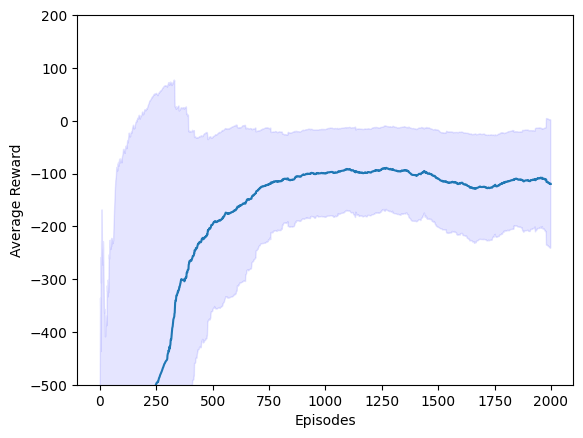

In [ ]:
def plot_rewards(rewards):
    avg_rew = []
    std_dev = []
    plt.figure("Reward Plot")
    scores_window = deque(maxlen=300)
    for reward in rewards:
        scores_window.append(reward)
        avg_rew.append(np.mean(scores_window))
        std_dev.append(np.std(scores_window))
    plt.plot(avg_rew)
    plt.fill_between(range(len(avg_rew)), np.subtract(avg_rew, std_dev), np.add(avg_rew, std_dev), color='b', alpha=0.1)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.ylim(-500, 200)  # Set the Y-axis range

plot_rewards(total_rewards)

In [ ]:
print(np.mean(total_rewards[-100:]))

-149.22032190172203
